# Notebook 1: Creation of the Train Set

#### **TL;DR**
As part of our effort to create an **efficient object detection dataset** for images featuring people or pets, we used Microsoft's Florence-2-large model for labeling, normalized the bounding box coordinates, and removed small objects. Finally, we split the data into training and validation sets.

### Imports and definitions

In [2]:
!pip install -q kaggle
!pip install flash_attn einops timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 27.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 90.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cuspa

In [3]:
from transformers import AutoProcessor, AutoModelForCausalLM
import os
from google.colab import drive
import random
import zipfile
import pandas as pd
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import yaml
from sklearn.model_selection import train_test_split
import shutil
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import cv2
import random
import time

%matplotlib inline

custom_palette = ['#1f77b4', '#ff7f0e']

In [4]:
drive.mount('/content/drive')
BASE_PATH = '/content/drive/MyDrive/people-and-pets-recognition/' # Set your google drive path here

# Define paths for train and valid
IMAGES_PATH = os.path.join(BASE_PATH, 'flickr30k_filtered_images')
TRAIN_IMAGES_PATH = os.path.join(BASE_PATH, 'dataset/images/train')
VAL_IMAGES_PATH = os.path.join(BASE_PATH, 'dataset/images/val')
TRAIN_LABELS_PATH = os.path.join(BASE_PATH, 'dataset/labels/train')
VAL_LABELS_PATH = os.path.join(BASE_PATH, 'dataset/labels/val')

# Create directories if they don't exist
os.makedirs(BASE_PATH, exist_ok=True)
os.makedirs(IMAGES_PATH, exist_ok=True)
os.makedirs(TRAIN_IMAGES_PATH, exist_ok=True)
os.makedirs(VAL_IMAGES_PATH, exist_ok=True)
os.makedirs(TRAIN_LABELS_PATH, exist_ok=True)
os.makedirs(VAL_LABELS_PATH, exist_ok=True)

Mounted at /content/drive


### Download Flickr Images

In [5]:
!kaggle datasets download -d hsankesara/flickr-image-dataset
!unzip -o -q flickr-image-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/hsankesara/flickr-image-dataset
License(s): CC0-1.0
100% 8.14G/8.16G [00:35<00:00, 250MB/s]
100% 8.16G/8.16G [00:36<00:00, 243MB/s]


In [6]:
csv_path = 'flickr30k_images/results.csv'
df = pd.read_csv(csv_path, sep='|', header=None, names=['image', 'caption_number', 'caption'])

In [7]:
df['caption'] = df['caption'].fillna('')

In [8]:
keywords = {
    'cat': [r'\bcat\b', r'\bcats\b'],
    'dog': [r'\bdog\b', r'\bdogs\b'],
    'person': [r'\bmen\b', r'\bman\b', r'\bwomen\b', r'\bwoman\b', r'\bkid\b', r'\bkids\b', r'\bchildren\b', r'\bchildrens\b', r'\bchild\b', r'\bperson\b']
}

In [9]:
selected_images = []

for category, words in keywords.items():
    filtered_df = df[df['caption'].str.contains('|'.join(words), case=False, regex=True)]
    filtered_images = filtered_df['image'].unique()
    if category == 'cat':
        count = 700
    elif category == 'dog':
        count = 700
    elif category == 'person':
        count = 1000

    selected_images += list(filtered_images[:count])

In [10]:
os.makedirs(IMAGES_PATH, exist_ok=True)
image_dir = 'flickr30k_images/flickr30k_images'
for image in selected_images:
    src = os.path.join(image_dir, image)
    dst = os.path.join(IMAGES_PATH, image)
    os.system(f'cp "{src}" "{dst}"')

In [11]:
IMAGES_PATH = os.path.join(BASE_PATH, 'flickr30k_filtered_images')

### Microsoft's Florence-2-large

An advanced natural language processing model designed for a wide range of tasks, including text generation and **image captioning**.
The output of its object detector tool is a set of bounding boxes that enclose the objects in the image, along with class labels and confidence scores for each box. In this project, we decided to exclude the confidence scores due to concerns about complexity and reliability issues.

In [12]:
model_id = 'microsoft/Florence-2-large'
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True, token=False).eval().cuda()
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True, token=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/2.44k [00:00<?, ?B/s]

configuration_florence2.py:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_florence2.py:   0%|          | 0.00/127k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- modeling_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [13]:
def florence(task_prompt, image):
    prompt = task_prompt
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    generated_ids = model.generate(
      input_ids=inputs["input_ids"].cuda(),
      pixel_values=inputs["pixel_values"].cuda(),
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height)
    )
    return parsed_answer

In [14]:
# Update get_label to also return confidence
def get_label(labels, bboxes):
    pet_label = 'pet'
    person_label = 'person'
    animal_labels = ['cat', 'dog']
    people_labels = ['man', 'woman', 'person', 'human face', 'boy', 'girl']

    for label, bbox in zip(labels, bboxes):
        if label in animal_labels:
            return pet_label, bbox
        if label in people_labels:
            return person_label, bbox
    return None, None


### Deciding Min/Max values for images

Later in this notebook we'll present our selected model, which is **YOLOv8**. This model has **built-in functionality to resize images** during the training and inference processes. This resizing capability ensures that all images are transformed to a **consistent size** that the model can handle efficiently.

### Deciding Min/Max values for objects

To enhance the accuracy of the labeling process, we decided to exclude labels of objects smaller than 32x32 pixels.
Objects of this size are typically not the main subjects of interest in the images and may introduce noise into the model training process.

In the next cell, you will find an example that illustrates the efficient impact of our choice to filter out objects of this size.

In [15]:
def clean_small_objects(result, min_size=(32, 32)):
    labels = result['<OD>']['labels']
    bboxes = result['<OD>']['bboxes']

    filtered_labels = []
    filtered_bboxes = []

    for label, bbox in zip(labels, bboxes):
        width = bbox[2] - bbox[0]
        height = bbox[3] - bbox[1]

        if width >= min_size[0] and height >= min_size[1]:
            filtered_labels.append(label)
            filtered_bboxes.append(bbox)

    return filtered_labels, filtered_bboxes

#### Example for excluding small objects

Excluding small objects (smaller than 32x32 pixels) has significantly **reduced the number of labels** for this image.

Initially, the labels included all the birds in the image. After applying the exclusion criteria, the noisy birds in the background were removed. This process effectively removes insignificant objects, potentially **enhancing the model's performance** by focusing on more meaningful objects.

In [16]:
image_url = 'https://im.indiatimes.in/media/content/2017/Apr/1www_libertylines_it_1493371175_725x725.jpg'
!wget -O person.jpg "{image_url}" -q

Labels before: ['bird', 'bird', 'bird', 'bird', 'bird', 'bird', 'bird', 'bird', 'bird', 'bird', 'bird', 'bird', 'bird', 'bird', 'bird', 'bird', 'bird', 'bird', 'bird', 'bird', 'bird', 'bird', 'bird', 'bird', 'bird', 'bird', 'bird', 'bird', 'bird', 'bird', 'bird', 'bird', 'bird', 'bird', 'bird', 'bird', 'person']
Labels after: ['bird', 'bird', 'bird', 'bird', 'bird', 'bird', 'person']


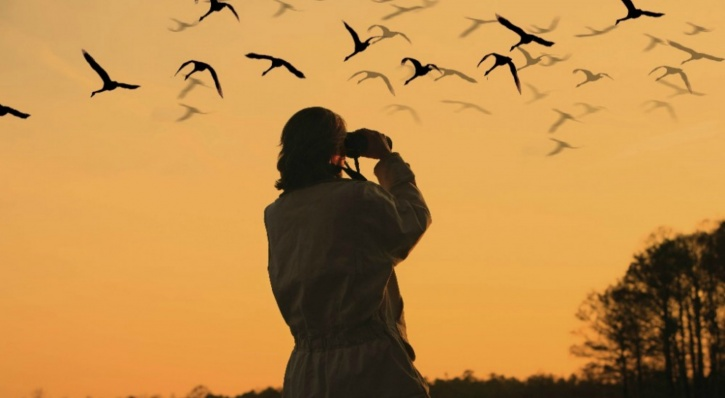

In [17]:
image_path = 'person.jpg'
image = Image.open(image_path)

task_prompt = '<OD>'
result_text = florence(task_prompt, image)
small_object_labels = result_text['<OD>']['labels']
print("Labels before: " + str(small_object_labels))
small_object_labels = clean_small_objects(result_text)[0]
print("Labels after: " + str(small_object_labels))

image

### Building the Dataset with Florence-2-large

We are constructing a dataset of images and labels containing 'person' and 'pet' using Microsoft's Florence-2-large tool. The implementation processes images in batches of 500 for resource efficiency, particularly due to the use of GPU.

For each image, we:

1. **Add a label**: Utilize the Florence model to generate labels ('person' or 'pet'). **Note:** There ate images with both person and pet, and in these photos we chose to prioritize the pets.
2. **Reduce labels**: Clean the labels generated by Florence by removing small objects (smaller than 32x32 pixels).
3. **Save the label**: Store 'person' or 'Pet' label for each image.

Using these images and their corresponding labels, we then build the dataset.

In [18]:
filenames = [f for f in os.listdir(IMAGES_PATH) if f.endswith('.jpg')]

In [19]:
# Function to process images and generate labels, coordinates, and confidences
def classify_images_with_florence(filenames):
    images = []
    labels = []
    coordinates = []

    for filename in filenames:
        file_path = os.path.join(IMAGES_PATH, filename)
        try:
            image = Image.open(file_path)
            task_prompt = '<OD>'
            result_text = florence(task_prompt, image)
            labels_clean, bboxes_clean = clean_small_objects(result_text)
            label, bbox = get_label(labels_clean, bboxes_clean)

            if label:
                images.append(filename)
                labels.append(label)
                coordinates.append(bbox)
            else:
                images.append('None')
                labels.append('None')
                coordinates.append('None')

        except Exception as e:
            print(f"Error processing image {file_path}: {e}")

    return images, labels, coordinates

In [20]:
# Process all files initially to gather all labels
all_images, all_labels, all_coordinates = classify_images_with_florence(filenames)

In [21]:
# Create DataFrame for labels
dataset = pd.DataFrame({'image': all_images, 'label': all_labels, 'coordinates': all_coordinates})

### Data cleaning

Cleaning and preprocessing the data is the most important step for the learning process of the model. In this case, it's crucial to deal with missing labels or coordinated since they are a great part of the model training process.

In [22]:
dataset['label'] = dataset['label'].replace('None', None)
dataset['coordinates'] = dataset['coordinates'].replace('None', None)

In [23]:
# Check for NaNs
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1751 entries, 0 to 1750
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image        1751 non-null   object
 1   label        1722 non-null   object
 2   coordinates  1722 non-null   object
dtypes: object(3)
memory usage: 41.2+ KB


In [24]:
cleaned_dataset = dataset.dropna().loc[(dataset['image'] != 'None') & (dataset['label'] != 'None') & dataset['coordinates'] != 'None']

In [25]:
# Function to normalize a single bounding box using the image size
def normalize_single_bbox(bbox, image_size):
    x_min, y_min, x_max, y_max = bbox
    img_width, img_height = image_size
    x_center = ((x_min + x_max) / 2) / img_width
    y_center = ((y_min + y_max) / 2) / img_height
    width = (x_max - x_min) / img_width
    height = (y_max - y_min) / img_height
    return [x_center, y_center, width, height]

# Function to normalize all bounding boxes in a list
def normalize_bboxes(bboxes, image_size):
    return [normalize_single_bbox(bbox, image_size) for bbox in bboxes]

# Normalize the coordinates column
def get_image_size(image_path):
    image = cv2.imread(image_path)
    return image.shape[1], image.shape[0]  # (width, height)

def normalize_row(row):
    image_path = os.path.join(IMAGES_PATH, row['image'])
    image_size = get_image_size(image_path)
    return normalize_single_bbox(row['coordinates'], image_size)

cleaned_dataset['coordinates'] = cleaned_dataset.apply(normalize_row, axis=1)

[0.6430000193681498, 0.5045, 0.4090000224262787, 0.632]
[210, 94, 405, 410]


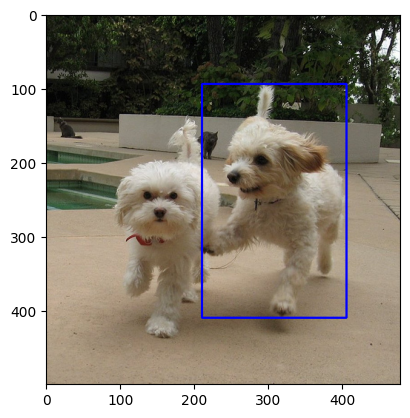

In [26]:
# Function to denormalize the bounding box for visualization
def denormalize_single_bbox(bbox, image_size):
    x_center, y_center, width, height = bbox
    img_width, img_height = image_size
    x_min = int((x_center - width / 2) * img_width)
    y_min = int((y_center - height / 2) * img_height)
    x_max = int((x_center + width / 2) * img_width)
    y_max = int((y_center + height / 2) * img_height)
    return [x_min, y_min, x_max, y_max]

# Function to visualize an image with its bounding box
def visualize_bbox(image, bbox):
    x_min, y_min, x_max, y_max = bbox
    image_copy = image.copy()
    cv2.rectangle(image_copy, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
    plt.imshow(cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB))
    plt.show()

sample_index = 15
sample_image_path = cleaned_dataset.loc[sample_index, 'image']
sample_image_path = os.path.join(IMAGES_PATH, sample_image_path)
sample_image = cv2.imread(sample_image_path)

image_size = sample_image.shape[1], sample_image.shape[0]
sample_bbox = cleaned_dataset.loc[sample_index, 'coordinates']
denormalized_bbox = denormalize_single_bbox(sample_bbox, image_size)

print(sample_bbox)
print(denormalized_bbox)
visualize_bbox(sample_image, denormalized_bbox)

### Final count of images for person and pet classes

In [27]:
# Count the occurrences of each label
label_counts = cleaned_dataset['label'].apply(lambda x: 'Person' if 'person' in x else 'Pet' if 'pet' in x else 'Other')
label_counts = label_counts.value_counts()

# Data for plotting
labels = ['Person', 'Pet']
counts = [label_counts.get('Person', 0), label_counts.get('Pet', 0)]
total_count = sum(counts)

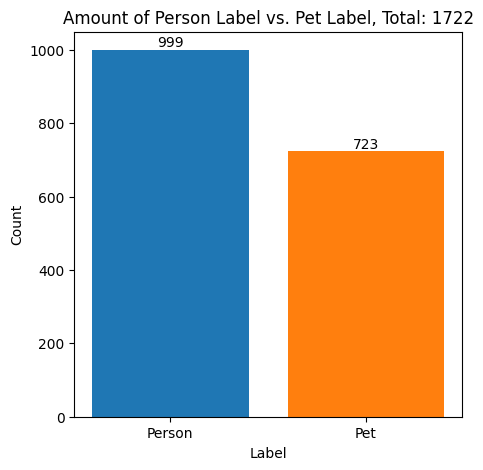

In [28]:
# Visualize

fig, ax = plt.subplots(figsize=(5, 5))
ax.bar(labels, counts, color=custom_palette)

for i, count in enumerate(counts):
    ax.text(i, count + 1, str(count), ha='center', va='bottom')

plt.title(f'Amount of Person Label vs. Pet Label, Total: {total_count}')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

### Use of TTA and Ensembles to verify the Florence annotations

Using Test Time Augmentations (TTA) and model ensembles can help verify the annotations made with Florence for our YOLO project:
* TTA - Involves applying different augmentations during testing and combining the predictions, which helps identify any mismatches with the original labels.

* Model ensembles - Provide multiple predictions for each image, and comparing these with the original annotations can reveal potential errors.

This approach ensures our labeled data is accurate, improving the reliability of our YOLO model's training inputs.

### Split to Train and Validation

Split the data into train and validation, with a minimum of **500 train** images and labels, and **100 valid** images and labels **per class**.


In [29]:
# Split by class
person_images = cleaned_dataset[cleaned_dataset['label'] == 'person']
pet_images = cleaned_dataset[cleaned_dataset['label'] == 'pet']

In [30]:
# Ensure minimum 500 training and 100 validation images for each class
def sample_minimum_images(df, min_train, min_val):
    if len(df) < min_train + min_val:
        raise ValueError(f"Not enough images for class. Found {len(df)}, required {min_train + min_val}.")

    train_images, val_images = train_test_split(df, test_size=min_val, random_state=42)
    if len(train_images) < min_train:
        train_images = train_images.append(df.sample(min_train - len(train_images), replace=True, random_state=42))
    if len(val_images) < min_val:
        val_images = val_images.append(df.sample(min_val - len(val_images), replace=True, random_state=42))
    return train_images, val_images


In [31]:
# Sample minimum required images
train_person, val_person = sample_minimum_images(person_images, 500, 150)
train_pet, val_pet = sample_minimum_images(pet_images, 500, 100)

In [32]:
# Combine train and val datasets
train_df = pd.concat([train_person, train_pet])
val_df = pd.concat([val_person, val_pet])

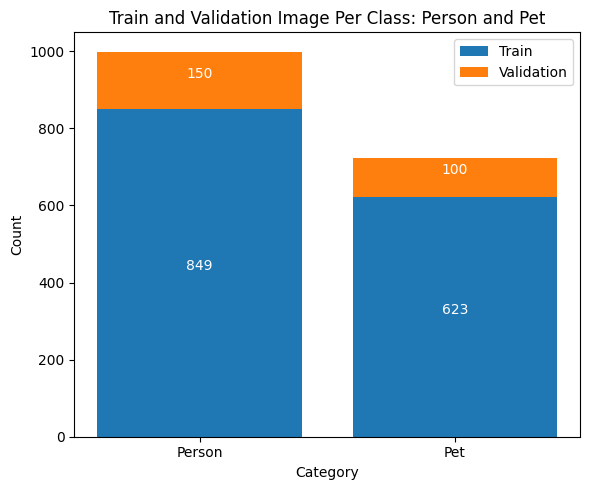

In [33]:
# Visualization

train_person_count = len(train_person)
val_person_count = len(val_person)
train_pet_count = len(train_pet)
val_pet_count = len(val_pet)

categories = ['Person', 'Pet']
train_counts = [train_person_count, train_pet_count]
val_counts = [val_person_count, val_pet_count]

fig, ax = plt.subplots(figsize=(6, 5))
bars_train = ax.bar(categories, train_counts, color=custom_palette[0], label='Train')
bars_val = ax.bar(categories, val_counts, bottom=train_counts, color=custom_palette[1], label='Validation')

for i, bar in enumerate(bars_train):
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval / 2, int(yval), ha='center', va='bottom', color='white')

for i, bar in enumerate(bars_val):
    yval = bar.get_height() + bars_train[i].get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval - bar.get_height() / 2, int(bar.get_height()), ha='center', va='bottom', color='white')

ax.set_xlabel('Category')
ax.set_ylabel('Count')
ax.set_title('Train and Validation Image Per Class: Person and Pet')
ax.legend()

plt.tight_layout()
plt.show()

### Fill the Train and Validation directories

In [34]:
# Function to copy files to train and val directories
def copy_files_to_directories(filenames, labels, coordinates, image_dest, label_dest):
    for i, filename in enumerate(filenames):
        file_path = os.path.join(IMAGES_PATH, filename)
        label = labels[i]
        coord = coordinates[i]

        if label == 'person':
            class_id = 0
        elif label == 'pet':
            class_id = 1
        else:
            class_id = -1

        label_file_path = os.path.join(label_dest, filename.replace('.jpg', '.txt'))
        with open(label_file_path, 'w') as f:
            if coord:
                x_min, y_min, x_max, y_max = coord
                f.write(f'{class_id} {x_min} {y_min} {x_max} {y_max}')
            else:
                f.write(f'{class_id} 0.5 0.5 0.5 1 1')  # Dummy label in YOLO format

        dest_file_path = os.path.join(image_dest, filename)
        if os.path.abspath(file_path) != os.path.abspath(dest_file_path):
            image = Image.open(file_path)
            image.save(dest_file_path)

In [35]:
# Function to count the number of files in a directory
def count_files_in_directory(directory):
    return len([name for name in os.listdir(directory) if os.path.isfile(os.path.join(directory, name))])

In [36]:
# Function to ensure all files are copied
def ensure_all_files_copied(filenames, image_dest, label_dest):
    expected_file_count = len(filenames)
    while True:
        image_file_count = count_files_in_directory(image_dest)
        label_file_count = count_files_in_directory(label_dest)
        if image_file_count == expected_file_count and label_file_count == expected_file_count:
            break
        time.sleep(1)  # Wait for 1 second before checking again
    print("All files copied successfully.")

In [37]:
# Copy train files
train_images = train_df['image'].tolist()
train_labels = train_df['label'].tolist()
train_coordinates = train_df['coordinates'].tolist()
copy_files_to_directories(train_images, train_labels, train_coordinates, TRAIN_IMAGES_PATH, TRAIN_LABELS_PATH)
ensure_all_files_copied(train_images, TRAIN_IMAGES_PATH, TRAIN_LABELS_PATH)

All files copied successfully.


In [38]:
# Copy val files
val_images = val_df['image'].tolist()
val_labels = val_df['label'].tolist()
val_coordinates = val_df['coordinates'].tolist()
copy_files_to_directories(val_images, val_labels, val_coordinates, VAL_IMAGES_PATH, VAL_LABELS_PATH)
ensure_all_files_copied(val_images, VAL_IMAGES_PATH, VAL_LABELS_PATH)

All files copied successfully.


# Sammury of the Train Set creation part

Our final goal in this project was to create an **efficient object detection model** tailored for images featuring either people or pets (a union of dogs and cats).
In this part, we utilized Microsoft's Florence-2-large model to label our dataset and generate bounding box coordinates. The dataset was then cleaned by **removing small objects** smaller than 32 pixels, as the YOLO model we intended to train cannot effectively learn from such small objects. After ensuring data consistency and normalizing the bounding box coordinates, the dataset was split into training and validation sets, ensuring a minimum of 500 training images and 100 validation images per class.

### **Steps along the way**

**1 - Images**
* Took about 1800 images from the 'Flicker image dataset' in Kaggle.

**2 - Labeling Images with Florence-2-Large Model**
* Used the Florence-2-Large model by Microsoft to generate labels for images.

**3 - Building the Dataset**
* Deleting Small Objects: Removed objects too small to be significant for training.
* Choosing Labels: Selected one of two labels 'Person' or 'Pet' for training purposes, prioritizing 'pet' over 'person' in images containing both.

**4 - Cleaning the Data**
* Ensured data consistency and correctness.
* Normalized bounding box coordinates since the YOLO model requires normelized bbox values.

**5 - Data Segmentation**
* Divided data into training and validation sets with minimum 500 train images and 100 validation images per class.
* Organized images and labels into appropriate directories to match the requirments of the YOLO model: dataset/images/train, dataset/images/val, dataset/labels/train, dataset/labels/val.

### **Conclusions**
The creation of the training dataset involved careful preprocessing to ensure **high-quality data for model training**. Labeling accuracy, data cleaning, and proper segmentation were crucial in building a **reliable dataset**, setting a solid foundation for subsequent training and evaluation of the model.

### References:
* Florence - https://blog.roboflow.com/florence-2/
* Flickr Image dataset - https://www.kaggle.com/datasets/hsankesara/flickr-image-dataset